In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from image_similarity_measures.evaluate import evaluation
from skimage.metrics import structural_similarity as ssim
from PIL import Image
import numpy as np
from scipy.spatial.distance import directed_hausdorff
import cv2 as cv
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from sklearn.metrics.pairwise import cosine_similarity
import subprocess
import time
import seaborn as sns

c:\Users\Danish\AppData\Local\Programs\Python\Python310\lib\site-packages\phasepack\tools.py:11: UserWarning: 
Module 'pyfftw' (FFTW Python bindings) could not be imported. To install it, try
running 'pip install pyfftw' from the terminal. Falling back on the slower
'fftpack' module for 2D Fourier transforms.
  warnings.warn("""


# VGG16

In [2]:
vgg16 = VGG16(weights='imagenet', include_top=False, pooling='max', input_shape=(224, 224, 3))

# Freezing the layers
for model_layer in vgg16.layers:
    model_layer.trainable = False

def load_and_preprocess_image(image_path):
    """
    Load and preprocess an image for the VGG16 model.
    """
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded = np.expand_dims(img_array, axis=0)
    return preprocess_input(img_array_expanded)

def load_and_preprocess_image_greyscale(image_path):
    """
    Load and preprocess an image in grayscale for the VGG16 model, 
    ensuring it retains 3 channels (replicating the grayscale values across them).
    """
    # Load the image in grayscale mode
    img = image.load_img(image_path, target_size=(224, 224), color_mode='grayscale')
    
    # Convert the image to an array
    img_array = image.img_to_array(img)
    
    # Manually replicate the grayscale channel to make it 3 channels
    img_array_3channel = np.repeat(img_array, 3, axis=-1)
    
    # Expand dimensions to match the input shape expected by the model
    img_array_expanded = np.expand_dims(img_array_3channel, axis=0)
    
    # Preprocess the image (using VGG16 preprocess_input)
    return preprocess_input(img_array_expanded)

def get_image_embeddings(img_array):
    """
    Get image embeddings using the VGG16 model.
    """
    return vgg16.predict(img_array)

def get_similarity_score(first_image_path, second_image_path):
    """
    Compute the similarity score between two images.
    """
    first_image_array = load_and_preprocess_image(first_image_path)
    second_image_array = load_and_preprocess_image(second_image_path)
    first_image_embedding = get_image_embeddings(first_image_array)
    second_image_embedding = get_image_embeddings(second_image_array)
    return cosine_similarity(first_image_embedding, second_image_embedding)[0][0]

def get_similarity_score_greyscale(first_image_path, second_image_path):
    """
    Compute the similarity score between two images.
    """
    first_image_array = load_and_preprocess_image_greyscale(first_image_path)
    second_image_array = load_and_preprocess_image_greyscale(second_image_path)
    first_image_embedding = get_image_embeddings(first_image_array)
    second_image_embedding = get_image_embeddings(second_image_array)
    return cosine_similarity(first_image_embedding, second_image_embedding)[0][0]

# Hausdorff

In [7]:
def normalized_hausdorff_distance(img1, img2):
    # Find Canny edges for both images
    edges1 = cv.Canny(img1, 100, 200)
    edges2 = cv.Canny(img2, 100, 200)

    # Get the coordinates of edge points in both images
    points1 = np.column_stack(np.where(edges1 > 0))
    points2 = np.column_stack(np.where(edges2 > 0))

    # Compute directed Hausdorff distances
    d_forward = directed_hausdorff(points1, points2)[0]
    d_reverse = directed_hausdorff(points2, points1)[0]

    # Hausdorff distance is the max of the two directed distances
    hausdorff_dist = max(d_forward, d_reverse)

    # Calculate the diagonal of the image (the longest possible distance)
    height, width = img1.shape
    diagonal = np.sqrt(width**2 + height**2)

    # Normalize the Hausdorff distance by the diagonal
    normalized_dist = hausdorff_dist / diagonal
    return normalized_dist

# SSIM

In [12]:
def get_ssim_score(img1_path, img2_path):
    # Read the images
    img1 = cv.imread(img1_path)
    img2 = cv.imread(img2_path)

    # Ensure the images are the same size (optional)
    if img1.shape != img2.shape:
        print(f"Image shapes are different: {img1.shape} vs {img2.shape}")
        return -1  # Skip comparison if images are different sizes

    # Set win_size based on your image size (make sure it's smaller or equal to your smallest image dimension)
    win_size = min(img1.shape[0], img1.shape[1], 31)  # Set a reasonable window size

    # Compute SSIM for color images
    score, diff = ssim(img1, img2, win_size=win_size, channel_axis=-1, full=True)

    return score

# Misc.

In [13]:
def contraharmonic_mean_two_numbers(num1, num2):
    return (num1**2 + num2**2) / (num1 + num2)

def contraharmonic_mean_three_numbers(num1, num2, num3):
    return (num1 ** 2 + num2 ** 2 + num3 ** 2) / (num1 + num2 + num3)

def get_bpp(dim1, dim2, num_bytes):
    return num_bytes * 8 / (dim1 * dim2)

# SD1.5 Stats

In [3]:
sd_canny_input = 'canny_dataset'

sd_canny_dataset = [file for file in os.listdir(sd_canny_input)]
sd_canny_dataset = ["./" + sd_canny_input + "/" + x for x in sd_canny_dataset]

sd_images_input = 'images_dataset'

sd_images_dataset = [file for file in os.listdir(sd_images_input)]
sd_images_dataset = ["./" + sd_images_input + "/" + x for x in sd_images_dataset]

sd_images_recon_input = 'images_recon'

sd_images_recon = [file for file in os.listdir(sd_images_recon_input)]
sd_images_recon = ["./" + sd_images_recon_input + "/" + x for x in sd_images_recon]

sd_color_input = 'color_dataset'

sd_color_dataset = [file for file in os.listdir(sd_color_input)]
sd_color_dataset = ["./" + sd_color_input + "/" + x for x in sd_color_dataset]

sd_color_output = 'color_recon'

sd_color_recon = [file for file in os.listdir(sd_color_output)]
sd_color_recon = ["./" + sd_color_output + "/" + x for x in sd_color_recon]



In [4]:
sd_vgg_scores = []

for i in range(len(sd_images_dataset)):
    similarity_score = get_similarity_score(sd_images_dataset[i], sd_images_recon[i])
    sd_vgg_scores.append(similarity_score)

1/1 [==============================] - 0s 73ms/step


KeyboardInterrupt: 

In [110]:
sd_hausdorff_scores = []

for i in range(len(sd_images_dataset)):
    img1 = cv.imread(sd_images_dataset[i], 0)  # Load in grayscale
    img2 = cv.imread(sd_images_recon[i], 0)  # Load in grayscale

    distance = normalized_hausdorff_distance(img1, img2)
    sd_hausdorff_scores.append(distance)

sd_complement_hausdorff_scores = [1 - x for x in sd_hausdorff_scores]

In [111]:
sd_ssim_scores = []

for i in range(len(sd_images_dataset)):
    ssim_score = get_ssim_score(sd_color_dataset[i], sd_color_recon[i])
    sd_ssim_scores.append(ssim_score)

In [112]:
sd_contraharmonic_scores = [contraharmonic_mean_three_numbers(sd_vgg_scores[i], sd_complement_hausdorff_scores[i], sd_ssim_scores[i]) for i in range(len(sd_images_dataset))]

In [113]:
sd_bpp = []

for i in range(len(sd_images_dataset)):
    result = subprocess.run(['.\compression\jbig2', '-s', '-p', sd_canny_dataset[i]], text=True, capture_output=True)
    time.sleep(0.1)
    conditioning_input_size = (os.path.getsize('./output.0000') + os.path.getsize('./output.sym'))
    canny_image = cv.imread(sd_canny_dataset[i], 0)
    sd_bpp.append(get_bpp(canny_image.shape[0], canny_image.shape[1], conditioning_input_size))

In [114]:
with open('sd_times.txt', 'r') as file:
    # Read each line, strip newline characters, and store it in a list
    sd_generation_times = [float(line.strip()) for line in file.readlines()]

In [115]:
print("SD1.5")
print("Avg Contraharmonic mean scores:", np.mean(sd_contraharmonic_scores))
print("Avg BPP:", np.mean(sd_bpp))
print("Avg Generation time:", np.mean(sd_generation_times))
print("")
print("Contraharmonic list length:", len(sd_contraharmonic_scores))
print("BPP list length:", len(sd_bpp))
print("Generation time list length:", len(sd_generation_times))

SD1.5
Avg Contraharmonic mean scores: 0.8860111937955806
Avg BPP: 0.21022661592038175
Avg Generation time: 8.5

Contraharmonic list length: 148
BPP list length: 148
Generation time list length: 148


# DMD2 Stats

In [77]:
dmd2_canny_input = 'dmd2_canny_dataset'

dmd2_canny_dataset = [file for file in os.listdir(dmd2_canny_input)]
dmd2_canny_dataset = ["./" + dmd2_canny_input + "/" + x for x in dmd2_canny_dataset]

dmd2_images_input = 'dmd2_images_dataset'

dmd2_images_dataset = [file for file in os.listdir(dmd2_images_input)]
dmd2_images_dataset = ["./" + dmd2_images_input + "/" + x for x in dmd2_images_dataset]

dmd2_orig_images_recon_input = 'dmd2_orig_images_recon'

dmd2_orig_images_recon = [file for file in os.listdir(dmd2_orig_images_recon_input)]
dmd2_orig_images_recon = ["./" + dmd2_orig_images_recon_input + "/" + x for x in dmd2_orig_images_recon]

dmd2_mod_images_recon_input = 'dmd2_mod_images_recon'

dmd2_mod_images_recon = [file for file in os.listdir(dmd2_mod_images_recon_input)]
dmd2_mod_images_recon = ["./" + dmd2_mod_images_recon_input + "/" + x for x in dmd2_mod_images_recon]

In [78]:
contraharmonic_scores_dmd2 = []

for i in range(len(dmd2_images_dataset)):
    similarity_score_orig = get_similarity_score_greyscale(dmd2_images_dataset[i], dmd2_orig_images_recon[i])
    img1 = cv.imread(dmd2_images_dataset[i], 0)
    img2 = cv.imread(dmd2_orig_images_recon[i], 0)
    hausdorff_score_orig = normalized_hausdorff_distance(img1, img2)
    complement_hausdorff_score_orig = 1 - hausdorff_score_orig
    contraharmonic_score_orig = contraharmonic_mean_two_numbers(similarity_score_orig, complement_hausdorff_score_orig)

    similarity_score_mod = get_similarity_score_greyscale(dmd2_images_dataset[i], dmd2_mod_images_recon[i])
    img1 = cv.imread(dmd2_images_dataset[i], 0)
    img2 = cv.imread(dmd2_mod_images_recon[i], 0)
    hausdorff_score_mod = normalized_hausdorff_distance(img1, img2)
    complement_hausdorff_score_mod = 1 - hausdorff_score_mod
    contraharmonic_score_mod = contraharmonic_mean_two_numbers(similarity_score_mod, complement_hausdorff_score_mod)

    contraharmonic_scores_dmd2.append(max(contraharmonic_score_orig, contraharmonic_score_mod))

1/1 [==============================] - 0s 100ms/step


In [79]:
dmd2_dataset_image_sizes = [os.path.getsize(path) for path in dmd2_images_dataset]

dmd2_bpp = []

for i in range(len(dmd2_images_dataset)):
    result = subprocess.run(['.\compression\jbig2', '-s', '-p', dmd2_canny_dataset[i]], text=True, capture_output=True)
    time.sleep(0.1)
    conditioning_input_size = (os.path.getsize('./output.0000') + os.path.getsize('./output.sym'))
    canny_image = cv.imread(dmd2_canny_dataset[i], 0)
    dmd2_bpp.append(get_bpp(canny_image.shape[0], canny_image.shape[1], conditioning_input_size))

In [80]:
with open('dmd2_orig_times.txt', 'r') as file:
    # Read each line, strip newline characters, and store it in a list
    dmd2_orig_times = [float(line.strip()) for line in file.readlines()]

with open('dmd2_mod_times.txt', 'r') as file:
    # Read each line, strip newline characters, and store it in a list
    dmd2_mod_times = [float(line.strip()) for line in file.readlines()]

dmd2_generation_times = [min(dmd2_orig_times[i], dmd2_mod_times[i]) for i in range(len(dmd2_images_dataset))]

In [81]:
dmd2_contraharmonic_scores = contraharmonic_scores_dmd2

In [82]:
print("DMD2")
print("Avg Contraharmonic mean scores:", np.mean(dmd2_contraharmonic_scores))
print("Avg BPP:", np.mean(dmd2_bpp))
print("Avg Generation time:", np.mean(dmd2_generation_times))
print("")
print("Contraharmonic list length:", len(dmd2_contraharmonic_scores))
print("BPP list length:", len(dmd2_bpp))
print("Generation time list length:", len(dmd2_generation_times))

DMD2
Avg Contraharmonic mean scores: 0.8052921061598679
Avg BPP: 0.22754263452119589
Avg Generation time: 1.3857722830128025

Contraharmonic list length: 148
BPP list length: 148
Generation time list length: 148


# Flux Stats

In [83]:
flux_images_input = 'reduced_images_dataset'
flux_images_output = 'flux_images_recon'

flux_images_dataset = [file for file in os.listdir(flux_images_input)]
flux_images_dataset = ["./" + flux_images_input + "/" + x for x in flux_images_dataset]

flux_images_recon = [file for file in os.listdir(flux_images_output)]
flux_images_recon = ["./" + flux_images_output + "/" + x for x in flux_images_recon]

flux_canny_input = 'reduced_canny_dataset'

flux_canny_dataset = [file for file in os.listdir(flux_canny_input)]
flux_canny_dataset = ["./" + flux_canny_input + "/" + x for x in flux_canny_dataset]

In [84]:
flux_vgg_scores = []

for i in range(len(flux_images_dataset)):
    similarity_score = get_similarity_score(flux_images_dataset[i], flux_images_recon[i])
    flux_vgg_scores.append(similarity_score)

1/1 [==============================] - 0s 105ms/step


In [85]:
flux_hausdorff_scores = []

for i in range(len(flux_images_dataset)):
    img1 = cv.imread(flux_images_dataset[i], 0)  # Load in grayscale
    img2 = cv.imread(flux_images_recon[i], 0)  # Load in grayscale

    distance = normalized_hausdorff_distance(img1, img2)
    flux_hausdorff_scores.append(distance)

flux_complement_hausdorff_scores = [1 - x for x in flux_hausdorff_scores]

In [86]:
flux_contraharmonic_scores = [contraharmonic_mean_two_numbers(flux_vgg_scores[i], flux_complement_hausdorff_scores[i]) for i in range(len(flux_images_dataset))]

In [87]:
flux_bpp = []

for i in range(len(flux_images_dataset)):
    result = subprocess.run(['.\compression\jbig2', '-s', '-p', flux_canny_dataset[i]], text=True, capture_output=True)
    time.sleep(0.1)
    conditioning_input_size = (os.path.getsize('./output.0000') + os.path.getsize('./output.sym'))
    canny_image = cv.imread(flux_canny_dataset[i], 0)
    flux_bpp.append(get_bpp(canny_image.shape[0], canny_image.shape[1], conditioning_input_size))

In [88]:
with open('flux_times.txt', 'r') as file:
    # Read each line, strip newline characters, and store it in a list
    flux_generation_times = [float(line.strip()) for line in file.readlines()]

In [89]:
print("Flux")
print("Avg Contraharmonic mean scores:", np.mean(flux_contraharmonic_scores))
print("Avg BPP:", np.mean(flux_bpp))
print("Avg Generation time:", np.mean(flux_generation_times))
print("")
print("Contraharmonic list length:", len(flux_contraharmonic_scores))
print("BPP list length:", len(flux_bpp))
print("Generation time list length:", len(flux_generation_times))

Flux
Avg Contraharmonic mean scores: 0.8021005819355154
Avg BPP: 0.21270687489477252
Avg Generation time: 6.5000277467676115

Contraharmonic list length: 148
BPP list length: 148
Generation time list length: 148


# HiFiC Low Stats

In [90]:
hific_low_images_input = 'reduced_images_dataset'
hific_low_images_output = 'hific_low_images_recon'

hific_low_images_dataset = [file for file in os.listdir(hific_low_images_input)]
hific_low_images_dataset = ["./" + hific_low_images_input + "/" + x for x in hific_low_images_dataset]

hific_low_images_recon = [file for file in os.listdir(hific_low_images_output)]
hific_low_images_recon = ["./" + hific_low_images_output + "/" + x for x in hific_low_images_recon]

hific_low_color_input = 'color_dataset'

hific_low_color_dataset = [file for file in os.listdir(hific_low_color_input)]
hific_low_color_dataset = ["./" + hific_low_color_input + "/" + x for x in hific_low_color_dataset]

hific_low_color_output = 'hific_low_color_recon'

hific_low_color_recon = [file for file in os.listdir(hific_low_color_output)]
hific_low_color_recon = ["./" + hific_low_color_output + "/" + x for x in hific_low_color_recon]

In [91]:
hific_low_vgg_scores = []

for i in range(len(hific_low_images_dataset)):
    similarity_score = get_similarity_score(hific_low_images_dataset[i], hific_low_images_recon[i])
    hific_low_vgg_scores.append(similarity_score)

1/1 [==============================] - 0s 108ms/step


In [92]:
hific_low_hausdorff_scores = []

for i in range(len(hific_low_images_dataset)):
    img1 = cv.imread(hific_low_images_dataset[i], 0)  # Load in grayscale
    img2 = cv.imread(hific_low_images_recon[i], 0)  # Load in grayscale

    distance = normalized_hausdorff_distance(img1, img2)
    hific_low_hausdorff_scores.append(distance)

hific_low_complement_hausdorff_scores = [1 - x for x in hific_low_hausdorff_scores]

In [93]:
hific_low_ssim_scores = []

for i in range(len(hific_low_images_dataset)):
    ssim_score = get_ssim_score(hific_low_color_dataset[i], hific_low_color_recon[i])
    hific_low_ssim_scores.append(ssim_score)

In [94]:
hific_low_contraharmonic_scores = [contraharmonic_mean_three_numbers(hific_low_vgg_scores[i], hific_low_complement_hausdorff_scores[i], hific_low_ssim_scores[i]) for i in range(len(hific_low_images_dataset))]

In [95]:
hific_low_bpp = [float(x[40:45]) for x in hific_low_images_recon]

In [96]:
with open('hific_times.txt', 'r') as file:
    # Read each line, strip newline characters, and store it in a list
    hific_low_generation_times = [float(line.strip()) for line in file.readlines()]

In [97]:
print("HiFic Low")
print("Avg Contraharmonic mean scores:", np.mean(hific_low_contraharmonic_scores))
print("Avg BPP:", np.mean(hific_low_bpp))
print("Avg Generation time:", np.mean(hific_low_generation_times))
print("")
print("Contraharmonic list length:", len(hific_low_contraharmonic_scores))
print("BPP list length:", len(hific_low_bpp))
print("Generation time list length:", len(hific_low_generation_times))

HiFic Low
Avg Contraharmonic mean scores: 0.9695201289965054
Avg BPP: 0.29326351351351354
Avg Generation time: 2.2961169062434017

Contraharmonic list length: 148
BPP list length: 148
Generation time list length: 148


# Plotting

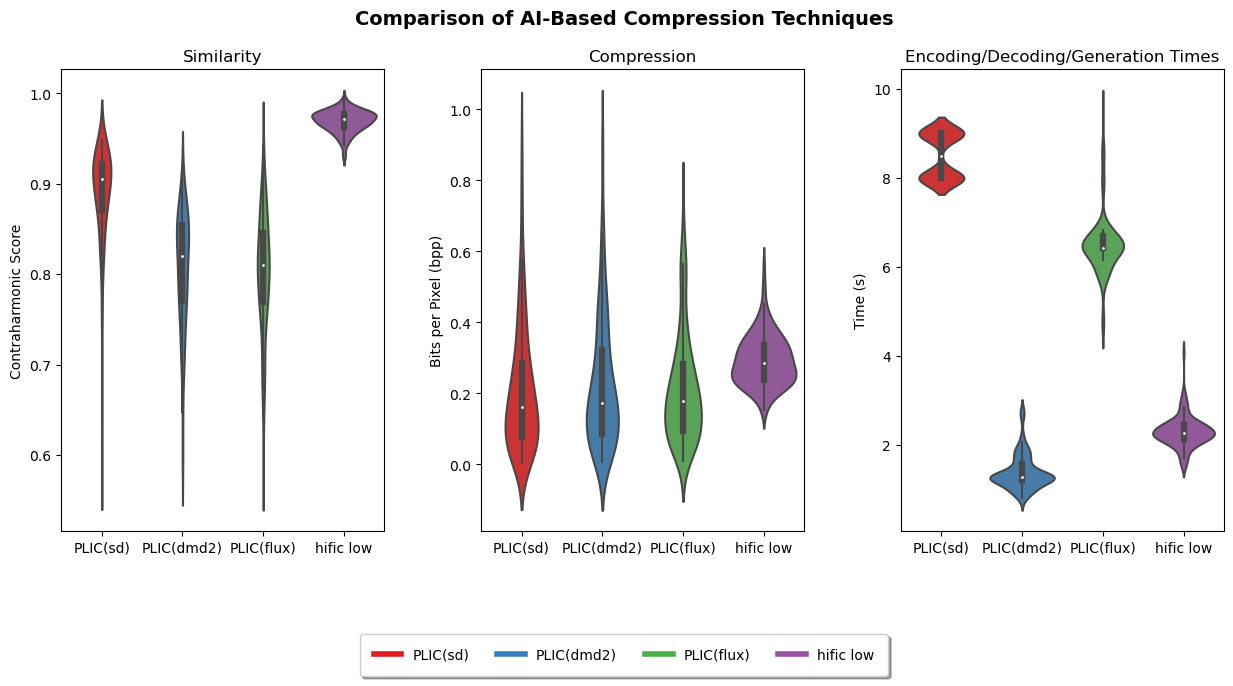

In [122]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Combine all data into lists (now including sd data)
contraharmonic_scores = sd_contraharmonic_scores + dmd2_contraharmonic_scores + flux_contraharmonic_scores + hific_low_contraharmonic_scores
bpp_scores = sd_bpp + dmd2_bpp + flux_bpp + hific_low_bpp
generation_times = sd_generation_times + dmd2_generation_times + flux_generation_times + hific_low_generation_times

# Labels for each data point (updated to include 'sd')
technique_labels = ['PLIC(sd)']*148 + ['PLIC(dmd2)']*148 + ['PLIC(flux)']*148 + ['hific low']*148

# Define a custom color palette using hex codes (updated to include 'sd')
custom_palette = {
    'PLIC(sd)': '#e41a1c',      # hex color for sd (stable diffusion)
    'PLIC(dmd2)': '#377eb8',    # hex color for dmd2
    'PLIC(flux)': '#4daf4a',    # hex color for flux
    'hific low': '#984ea3' # hex color for hific low
}

# Ensure technique_labels is categorical to match the palette
technique_labels = pd.Categorical(technique_labels, categories=custom_palette.keys())

# Set up the figure with 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 6), sharey=False)

# Plot Contraharmonic Score
sns.violinplot(ax=axs[0], x=technique_labels, y=contraharmonic_scores, palette=custom_palette)
axs[0].set_title('Similarity', fontsize=12)
axs[0].set_ylabel('Contraharmonic Score')

# Plot Bits per Pixel
sns.violinplot(ax=axs[1], x=technique_labels, y=bpp_scores, palette=custom_palette)
axs[1].set_title('Compression', fontsize=12)
axs[1].set_ylabel('Bits per Pixel (bpp)')

# Plot Generation Times
sns.violinplot(ax=axs[2], x=technique_labels, y=generation_times, palette=custom_palette)
axs[2].set_title('Encoding/Decoding/Generation Times', fontsize=12)
axs[2].set_ylabel('Time (s)')

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.3)

# Set the main title
plt.suptitle('Comparison of AI-Based Compression Techniques', fontsize=14, fontweight='bold')

# Add a legend (updated for 4 techniques)
handles = [plt.Line2D([0], [0], color=custom_palette[key], lw=4) for key in custom_palette]
labels = list(custom_palette.keys())
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=4, fancybox=True, framealpha=1, shadow=True, borderpad=1)

plt.show()


In [127]:
print(np.min(sd_bpp))

0.0037339154411764708


In [128]:
print(np.min(hific_low_bpp))

0.154
